本專題透過Kaggle用鐵達尼號生存預測比賽，使用探索性數據分析認識資料到特徵工程處理欄位的生存率、產生訓練集與測試集等產生模型預測資料。
此專案研究用意，對於人工智慧與大數據分析初學者建立程度外，使用pyton程式碼及相關套件實作，然後結合Kaggle 討論區中的文章，更深入來優化整個分析過程。


# 1.讀取資料

透過 Kaggle 資料競賽網站，下載鐵達尼號資料集。(Link: https://www.kaggle.com/c/titanic/data)

(點擊 "Download All" 後解壓縮，並透過下方程式碼上傳 gender_submission.csv, test.csv , train.csv 三份檔案)

※ 可一次上傳或分批上傳，上傳成功後，點擊左方 "Files" 欄位，即可看到上傳的檔案。 ※

In [1]:
# 忽略警告訊息
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, linear_model

# 載入數據
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')

print('train',df_train.shape)
display(df_train.head(5))
print('test',df_test.shape)
display(df_test.head(5))

train (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


test (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


透過 pandas 匯入訓練集與測試集資料，並利用 shape 得知資料的維度：

訓練集有 891 筆資料、12 個特徵欄位； 測試集有 418 筆資料、11 個特徵欄位； 其中，訓練集較測試集多了判別乘客罹難或生還的特徵欄位 Survived，0 表示罹難者，1 表示生還者。

In [2]:
# 合併train及test的資料 
df_data = df_train.append( df_test )
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


合併後訓練測試集總共有1309筆資料、12個特徵欄位，做出一致性的預測分析及模型訓練就會比較快速好理解。

# 2.生存率

首先，我們分析生還者與罹難者的比例是否有明顯極大的落差，比如生還者的比例僅有 1%，若資料有極大的落差時，表示存在『數據不平衡』(Imbalanced Data)的問題，則後續需用特別的方法對資料進行抽樣。 接下來，我們分別觀察性別(Sex)、票務艙(Pclass)、登船港口(Embarked)、兄弟姊妹配偶人數(SibSp)、父母子女人數(Parch)與生存率的關係。

In [3]:
# 顯示 dataframe
from IPython.display import display
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df_data in args:
        html_str+=df_data.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

,Sex,Survived
0,female,0.74
1,male,0.19


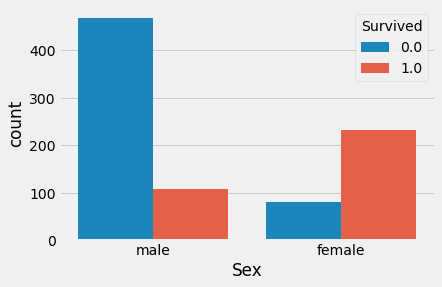

In [4]:
sns.countplot(df_data['Sex'], hue=df_data['Survived'])
df_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(2)

性別：大部的男性都罹難(僅剩約 19% 存活)，而女性則大部分都倖存(約 74%)

,Pclass,Survived
0,1,0.63
1,2,0.47
2,3,0.24


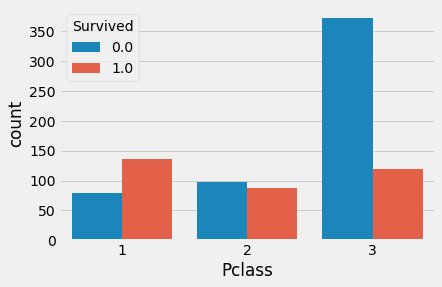

In [5]:
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(2)

艙等：從數據中可發現頭等艙(Pclass=1)的乘客生存機率較高， 可能不論是逃生設備或是沈船訊息都最先傳到頭等艙

,Embarked,Survived
0,C,0.55
1,Q,0.39
2,S,0.34


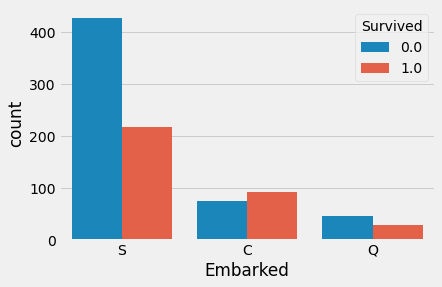

In [6]:
sns.countplot(df_data['Embarked'], hue=df_data['Survived'])
df_data[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().round(2)

登船港口:依據數據顯示出來的結果為生存率以C最高

,SibSp,Survived
0,0,0.35
1,1,0.54
2,2,0.46
3,3,0.25
4,4,0.17
5,5,0.00
6,8,0.00


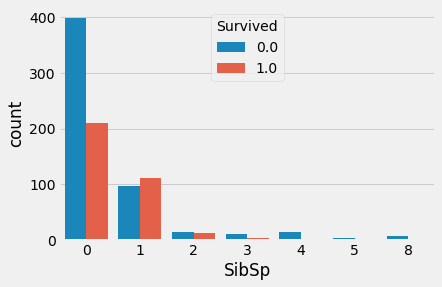

In [7]:
sns.countplot(df_data['SibSp'], hue=df_data['Survived'])
df_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().round(2)

當船上的兄弟姐妹配偶人數有1人同行時，則生存率較高

,Parch,Survived
0,0,0.34
1,1,0.55
2,2,0.50
3,3,0.60
4,4,0.00
5,5,0.20
6,6,0.00
7,9,NaN


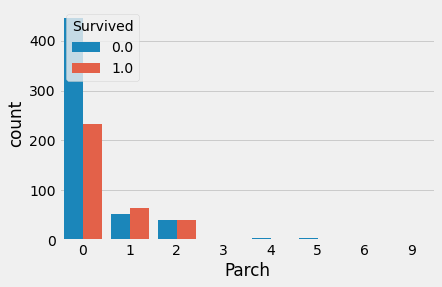

In [8]:
sns.countplot(df_data['Parch'], hue=df_data['Survived'])
df_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().round(2)

當船上的父母子女人數為 1~3 人時，有較高的生存率。

In [9]:
# 轉換性別資料：0->女性，1->男性
df_data['Sex_Code'] = df_data['Sex'].map({'female':1, 'male':0})
df_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1


Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

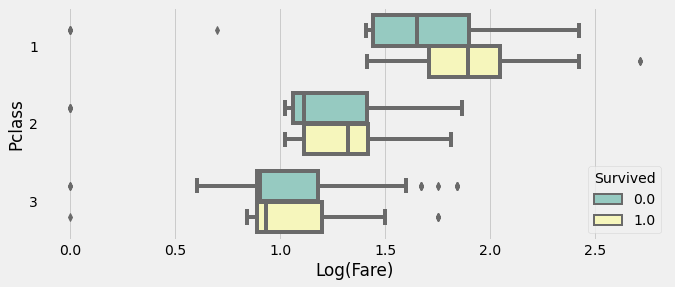

In [10]:
# 由於票價分布非常廣，所以將票價取 log 後再畫圖
fig, ax = plt.subplots(figsize = (10,4))
df_data['Log(Fare)'] = df_data['Fare'].map(lambda x:np.log10(x) if x>0 else 0)
sns.boxplot(x='Log(Fare)', y='Pclass', hue='Survived', data=df_data, orient='h', 
            ax=ax, palette="Set3")
pd.pivot_table(df_data, values=['Fare'], index=['Pclass'], columns=['Survived'], 
               aggfunc='median').round(3)

票價和艙等都是屬於彰顯乘客社會地位的一個特徵，買票價格較高的乘客，他們的生存機率也較高。

In [11]:
# 登船港口(Embarked)只有遺漏少數，直接補上出現次數最多的 S
df_data['Embarked'] = df_data['Embarked'].fillna('S')

# 費用(Fare)也只有遺漏一筆，因此就直接補上平均值
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].mean())

Age 遺漏筆數： 263


Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


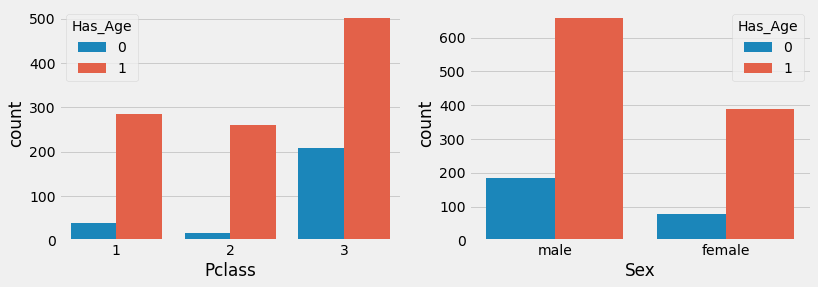

In [12]:
# 年紀(Age)的遺漏值較多，需好好思考如何填補
print('Age 遺漏筆數：', df_data['Age'].isnull().sum())

# 0->遺漏 Age
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x: 0 if x else 1)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
sns.countplot(df_data['Pclass'], hue=df_data['Has_Age'], ax=ax1)
sns.countplot(df_data['Sex'], hue=df_data['Has_Age'], ax=ax2)
pd.crosstab(df_data['Has_Age'], df_data['Sex'], margins=True).round(3)

# sns.countplot(df['Pclass'], hue=df['Has_Age'])

左圖：年紀遺漏值大部分在3等艙，如果年紀是個重要特徵，則我們對3等艙的觀察就會失真。
保守的作法是觀察1,2艙等中年紀對存活與否的影響
右圖：顯示了遺漏值對性別的分布，其中314位女性有53位缺失年齡(16.9%)，577位男性有124位缺失年齡(21.5%)，男性遺漏年紀的比例稍微多一點(~4.6%)。

Title,Master,Miss,Mr,Mrs,Rare
Pclass,,,,,
1,0,1,27,10,1
2,0,2,13,1,0
3,8,47,136,16,1


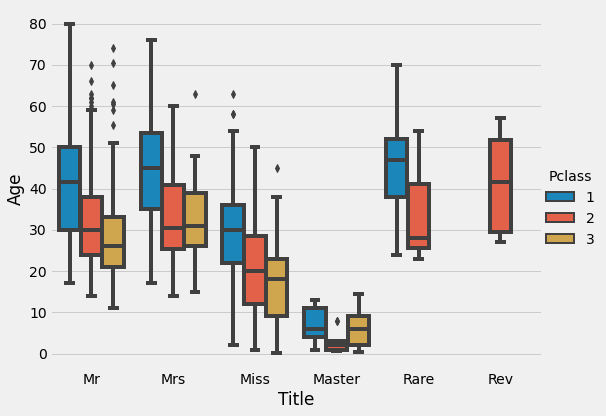

In [13]:
# 填入遺漏值的方式打算使用姓名中同稱謂的平均值來填補
# 取出姓名當中的稱謂
df_data['Title'] = df_data['Name'].str.extract('([A-Za-z]+)\.', expand=False)

title = df_data['Title'].value_counts().index
rare = title[5:]
df_data['Title'] = df_data['Title'].map(lambda x: 'Rare' if x in rare else x)
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms', 'Mme'], 'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'], 'Mrs')

sns.factorplot(x='Title', y='Age', kind='box', hue='Pclass', data=df_data, 
               size=6, aspect=1.3)

missing_mask = (df_data['Has_Age'] == 0)
pd.crosstab(df_data[missing_mask]['Pclass'], df_data[missing_mask]['Title'])

In [14]:
df_data['Title'] = df_data.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace( ['Ms','Mlle'], 'Miss' )
df_data['Title'] = df_data.Title.replace( 'Mme', 'Mrs' )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [15]:
# 將年齡的空值填入年齡的中位數
age_median = np.nanmedian(df_data['Age'])
print('年齡中位數=', age_median)
df_data.loc[df_data.Age.isnull(), 'Age'] = age_median

年齡中位數= 28.0


執行訓練出來的結果平均年齡中位數為28歲

# 3.產生訓練集(Train)與測試集(Test)

完成前述的資料分析及特徵工程後，我們就快可以把資料餵入模型進行訓練了！在此之前的最後一個注意步驟，就是需確認每個欄位皆為數值型態，且將資料分割回訓練集(train)與測試集(test)。所以，此時我們先檢視特徵工程後的資料，觀察是否還有需要處理的欄位：

In [16]:
print( f'Shape of data after feature engineering = {df_data.shape}' )
df_data.head()

Shape of data after feature engineering = (1309, 16)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code,Log(Fare),Has_Age,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0.860338,1,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1.852988,1,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0.898999,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1.725095,1,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0.905796,1,Mr


In [17]:
for col in ['Survived','Pclass','Sex','Age','Cabin','Ticket']:
    df_data[col] = df_data[col].astype('category').cat.codes

df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code,Log(Fare),Has_Age,Title
0,1,0,2,"Braund, Mr. Owen Harris",1,32,1,0,720,7.2500,-1,S,0,0.860338,1,Mr
1,2,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,57,1,0,816,71.2833,106,C,1,1.852988,1,Mrs
2,3,1,2,"Heikkinen, Miss. Laina",0,39,0,0,914,7.9250,-1,S,1,0.898999,1,Miss
3,4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,53,1,0,65,53.1000,70,S,1,1.725095,1,Mrs
4,5,0,2,"Allen, Mr. William Henry",1,53,0,0,649,8.0500,-1,S,0,0.905796,1,Mr


檢視後發現，因為我們之前有處理過字串欄位，所以資料中還存有 6 欄類別型態的欄位：Survived、Pclass、Sex、Age、Cabin、Ticket，因此，我們也需要將它們轉換成數值型態欄位：

In [18]:
print('new data')
df_data.info()
print()

new data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int8   
 2   Pclass       1309 non-null   int8   
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int8   
 5   Age          1309 non-null   int8   
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   int16  
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   int16  
 11  Embarked     1309 non-null   object 
 12  Sex_Code     1309 non-null   int64  
 13  Log(Fare)    1309 non-null   float64
 14  Has_Age      1309 non-null   int64  
 15  Title        1309 non-null   object 
dtypes: float64(2), int16(2), int64(5), int8(4), object(3)
memory usage: 162.7+ KB



執行後Survived、Pclass、Sex、Age、Cabin、Ticket的Dtype發現字元有變動了，接者就可以進行訓練。

# 4.訓練模型

最後將上述分析好的模型數字型態改變後，接者就可以將要訓練的模型欄位名作出預算，來評估模型的準確度是否能達到我們要求的水準。

In [19]:
label_encoder = preprocessing.LabelEncoder()
encoded_class = label_encoder.fit_transform(df_data["Pclass"])
X = pd.DataFrame([encoded_class, df_data["Sex"], df_data["Age"]]).T
y = df_data["Survived"]

In [20]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, y)
print('截距=',logistic.intercept_)
print('迴歸係數=',logistic.coef_)

截距= [ 0.02815188 -1.72730362  1.69915173]
迴歸係數= [[ 0.0130394   0.03838139  0.00175482]
 [ 0.52484732  1.20033692  0.01152415]
 [-0.53788672 -1.23871831 -0.01327897]]


In [21]:
print('Confusion Matrix')
preds = logistic.predict(X)
print(pd.crosstab(preds, df_data["Survived"]))
print(logistic.score(X, y))

Confusion Matrix
Survived   -1    0    1
row_0                  
-1         68   83   73
 0        237  427   73
 1        113   39  196
0.5278838808250573


特徵欄位所訓練出的模型準確率約 52.7%，我們可得知結果為一半左右的數值，特徵欄位進行訓練不見得會準確，對於模型的準確度將會有所提升。

In [22]:
submit.to_csv( 'Titanic_RandomForest.csv', index=False )
print( f'預測結果：' )
submit

預測結果：


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# 結論

使用 Kaggle 上鐵達尼號生存預測比賽，使用了性別、票務艙、登船港口、兄弟姊妹配偶人數、父母子女人數與生存率的關係做出相關關資料的分析及處理技巧，也用訓練模型、測試模型來預測、觀察及嘗試，運用在資料科學或機器學習專案作品上會能夠凸顯出學習經驗成訣竅。因此，一個專案要能順利進行且有收穫，除需具備熟練的程式語言外，該領域的專業知識及實務經驗，更是一大關鍵的因素，讓我們一同來學習成長！